ARIMA:

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecase errors.

- p : the order of AR term
- d : the number of differencing required to make the time series stationary
- q : the order of the MA term

Stationarity (time series is mean reverting):

The variance of the log of the prices increases slower than that of a random walk.
Price series that are found to be mean reverting.


In [1]:
from IPython.core.debugger import set_trace

# %load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import math

import warnings
warnings.filterwarnings('ignore')

plt.style.use(style='seaborn')
%matplotlib inline

In [2]:
df = pd.read_csv('./KAJARIACER.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,26.049999,28.200001,26.049999,27.000000,23.964306,877408
1,2010-01-05,27.125000,28.200001,26.875000,27.125000,24.075254,508398
2,2010-01-06,27.500000,28.400000,26.625000,26.825001,23.808989,402216
3,2010-01-07,27.250000,27.549999,26.850000,27.100000,24.053064,478980
4,2010-01-08,27.250000,28.025000,26.525000,26.700001,23.698040,366642


In [4]:
df = df[['Close']].copy()

In [5]:
df.describe()

,Close
count,2460.000000
mean,318.402673
std,233.812170
min,24.700001
25%,86.650002
50%,326.150009
75%,531.200012
max,753.000000


In [6]:
logScale = pd.DataFrame(np.log(df.Close))
df["CloseLogDiff"] = logScale - logScale.shift()

In [7]:
df = df.fillna(0)

An ARIMA model is characterized by 3 terms (p, d, q):
- p is the order of AR term
- d is the number of differencing required to make the time series stationary
- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.

#### Stationarity

Sibstract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times.
And the minimum number of differencing operations needed to make the series stationary needs to be imputed in to our ARIMA model.

ADF test

We'll use the Augmented Dickey Fuller(ADF) to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing

In [8]:
# Check if the price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f"ADF Statics: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statics: -1.1268633662848284
p-value: 0.7042410988761056


Autocorrelation Function (ACF): to find the differencing or the value of d

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

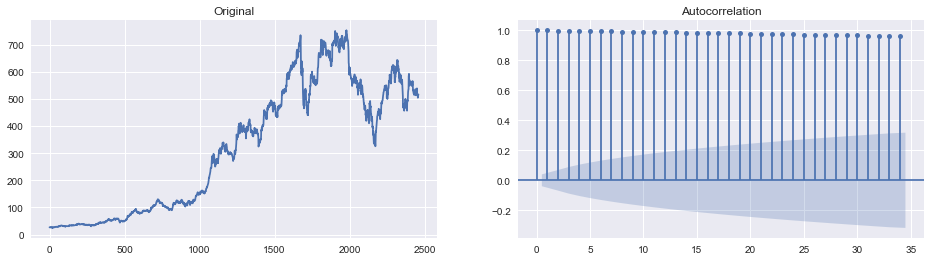

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(df.Close)
ax1.set_title('Original')
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.Close, ax=ax2);

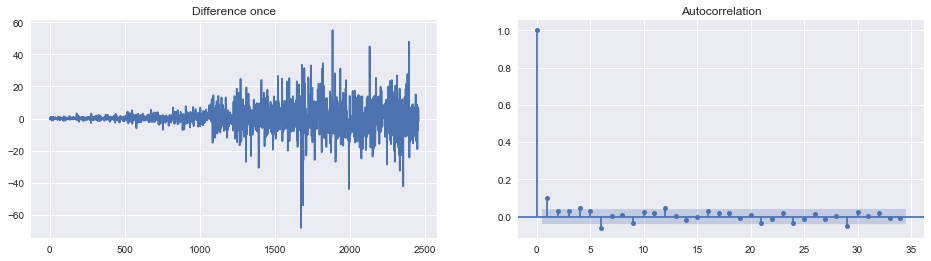

In [11]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

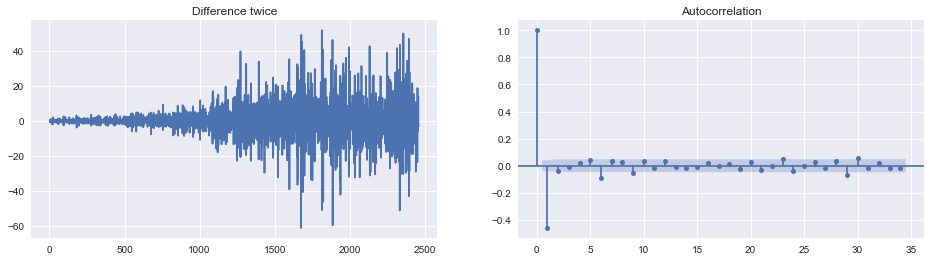

In [12]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

We can use the pmdarima package to get the number of differencing.

### d

In [13]:
#!pipenv install -skip-lock pmdarima
#conda install -c conda-forge pmdarima
print(np.__version__)
from pmdarima.arima.utils import ndiffs

1.21.0


In [14]:
from pmdarima.arima.utils import ndiffs
ndiffs(df.Close, test='adf')

1

### p
- p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.
- We can findout the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot
- The partial autocorrelation represents the correlation between the series and its lags.

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

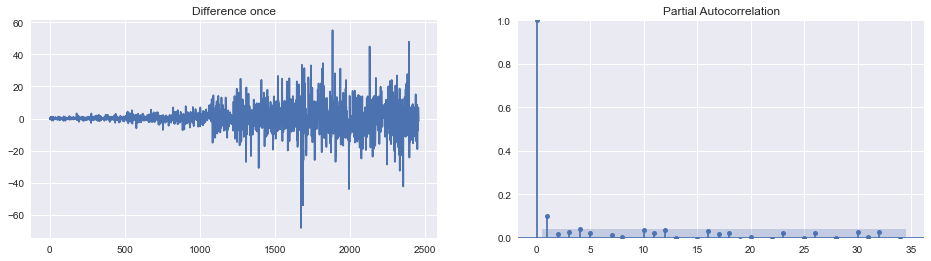

In [16]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

We can observe that the PACF lag 1 and 4 is signigicant as it's above the significance line. Will use 4

### q
- q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
- We can look at the ACF plot for the number of MA terms.

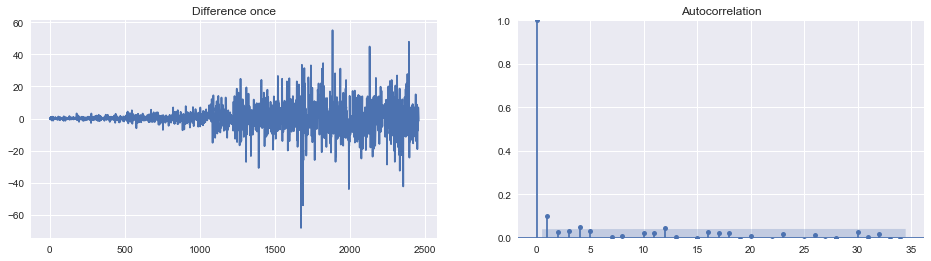

In [17]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Difference once')
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);

Forcast error 3 may be suitable for this model, hence using q as 3.

### Fitting the ARIMA model

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(df.Close, order=(4, 1, 3))
result = model.fit(disp=0)

In [19]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2459
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -8333.504
Method:                       css-mle   S.D. of innovations              7.171
Date:                Sun, 10 Apr 2022   AIC                          16685.008
Time:                        11:35:20   BIC                          16737.275
Sample:                             1   HQIC                         16703.999
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1986      0.175      1.138      0.255      -0.144       0.541
ar.L1.D.Close     0.3097      0.256      1.211      0.226      -0.191       0.811
ar.L2.D.Close    -0.7683      0.121     

(array([3.33974509e-05, 3.33974509e-05, 1.33589803e-04, 9.35128624e-04,
        7.38083664e-03, 6.26870153e-02, 9.38468369e-03, 1.23570568e-03,
        2.00384705e-04, 1.00192353e-04]),
 array([-67.79123966, -55.61458044, -43.43792122, -31.26126201,
        -19.08460279,  -6.90794357,   5.26871565,  17.44537486,
         29.62203408,  41.7986933 ,  53.97535251]),
 <BarContainer object of 10 artists>)

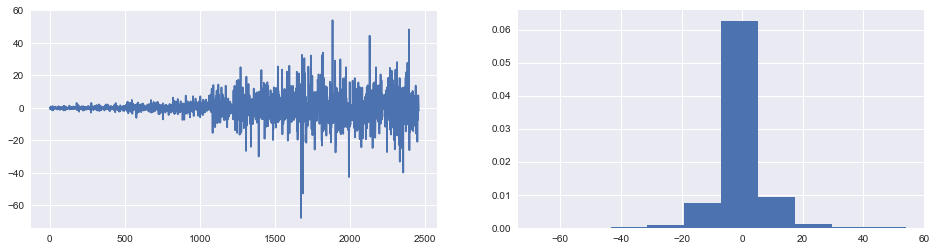

In [20]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)

find, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)

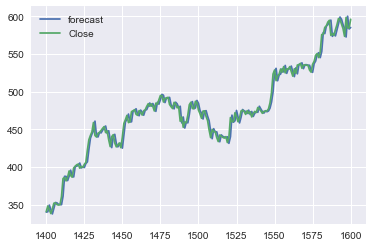

In [21]:
# Actual vs Fitted
result.plot_predict(start=1400, end=1600, dynamic=False);

### Train test split

In [22]:
df = pd.read_csv('./KAJARIACER.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', ascending=True, inplace=True)
df.set_index('Date', inplace=True)

In [23]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,26.049999,28.200001,26.049999,27.000000,23.964306,877408
2010-01-05,27.125000,28.200001,26.875000,27.125000,24.075254,508398
2010-01-06,27.500000,28.400000,26.625000,26.825001,23.808989,402216
2010-01-07,27.250000,27.549999,26.850000,27.100000,24.053064,478980
2010-01-08,27.250000,28.025000,26.525000,26.700001,23.698040,366642


In [24]:
# Train data = 90%, Test data = 10%
train_range = math.floor(len(df.index)*.9)
test_range = math.floor(len(df.index)*.1)

# Train DataFrame
train_df = df.Close[:train_range].sort_index()

# Test DataFrame
test_df = df.Close[train_range:].sort_index()

In [25]:
print(len(train_df))
print(len(test_df))

2214
246


In [26]:
test_df = test_df[38:238]

In [27]:
model = ARIMA(train_df, order=(4, 1, 3))
result = model.fit(disp=0)

C:\Soumen\AIML\Installs\Anaconda3\envs\tf-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Soumen\AIML\Installs\Anaconda3\envs\tf-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [28]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2213
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -7357.094
Method:                       css-mle   S.D. of innovations              6.722
Date:                Sun, 10 Apr 2022   AIC                          14732.188
Time:                        11:35:23   BIC                          14783.507
Sample:                             1   HQIC                         14750.935
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2087      0.169      1.232      0.218      -0.123       0.541
ar.L1.D.Close     0.4470      0.027     16.419      0.000       0.394       0.500
ar.L2.D.Close     0.2590      0.026     

In [29]:
step=200

fc, se, conf = result.forecast(step)

In [30]:
len(fc)

200

In [31]:
fc = pd.Series(fc, index=test_df[:step].index)
lower = pd.Series(conf[:,0], index=test_df[:step].index)
upper = pd.Series(conf[:,1], index=test_df[:step].index)

In [32]:
fc[0], test_df[0]

(487.8624966610456, 499.6499938964844)

In [33]:
fc[-1], test_df[step-1]

(530.5793249620386, 519.7000122070312)

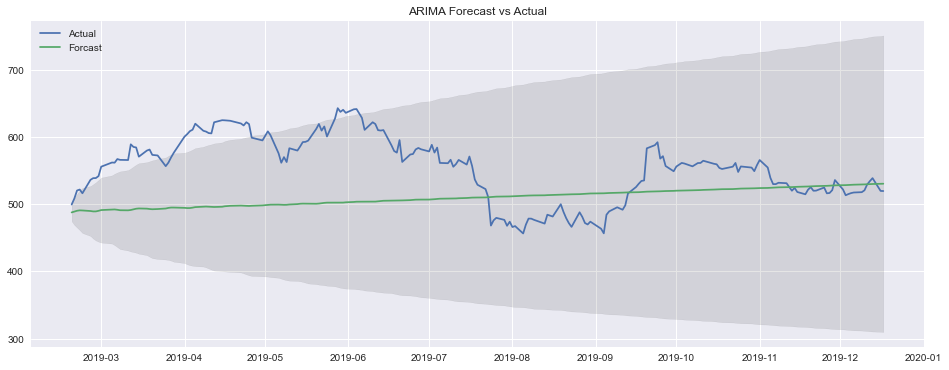

In [34]:
plt.figure(figsize=(16, 6))
plt.plot(test_df[:step], label='Actual')
plt.plot(fc, label='Forcast')
plt.fill_between(lower.index, lower, upper, color='k', alpha=0.1)
plt.title('ARIMA Forecast vs Actual')
plt.legend(loc='upper left')
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# report performance
mse = mean_squared_error(test_df[:step], fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_df[:step], fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_df[:step], fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_df[:step])/np.abs(test_df[:step]))
print('MAPE: '+str(mape))

MSE: 4765.89864728932
MAE: 57.17123242973421
RMSE: 69.03548831788851
MAPE: 0.09951386477093321


In [36]:
# % Growth in actual data 
round((test_df.iloc[-1] - test_df.iloc[0]) / test_df.iloc[0] * 100, 2)

4.01

In [37]:
# % Prediction difference 
round((test_df.iloc[-1] - fc[-1]) / fc[-1] *100, 2)

-2.05